# Foreign Exchange Forecasting

## Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

2023-06-11 21:38:57.339062: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-11 21:38:57.374869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 21:38:58.346895: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Constants

In [2]:
# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

## Pre-Processing

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1247 non-null   datetime64[ns]
 1   Close   1247 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


In [4]:
data.head()

,Date,Close
0,2020-01-01 23:58:00,13689.23
1,2020-01-02 23:58:00,13884.79
2,2020-01-03 23:58:00,13935.46
3,2020-01-04 23:58:00,13935.46
4,2020-01-05 23:58:00,13934.32


In [5]:
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

In [6]:
split_date = '1-Jan-2023'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [7]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

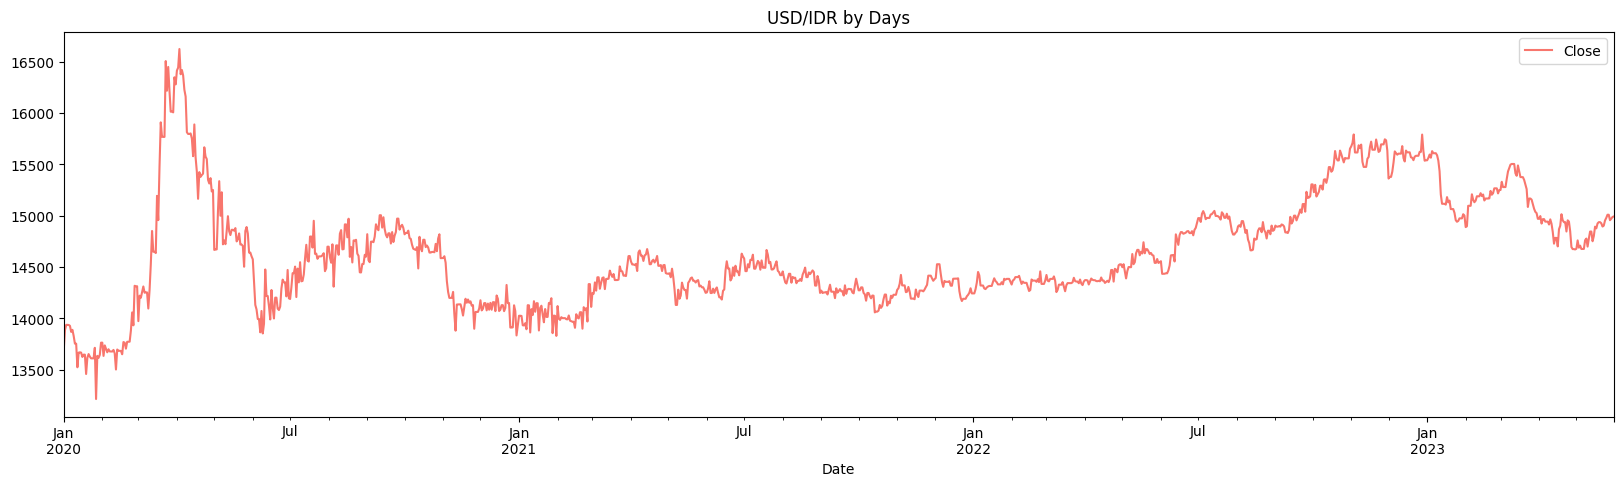

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(20,5), color=color_pal[0], title='USD/IDR by Days')

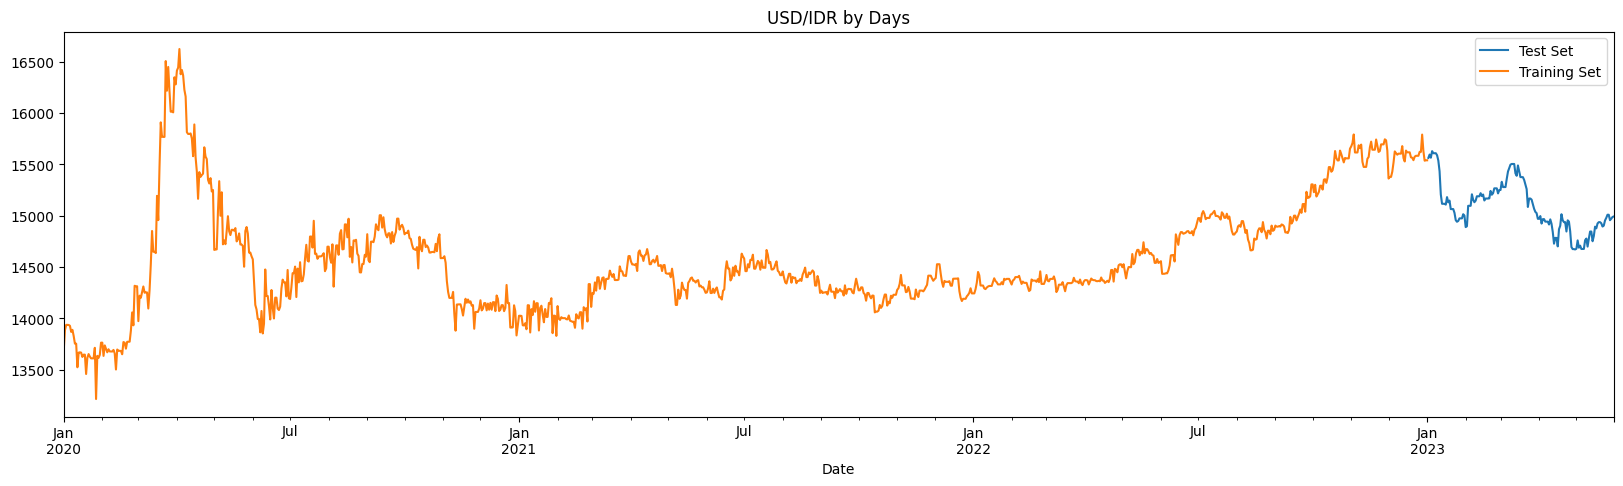

In [9]:
_ = data_test \
    .rename(columns={'Close': 'Test Set'}) \
    .join(data_train.rename(columns={'Close': 'Training Set'}), how='outer') \
    .plot(figsize=(20,5), title='USD/IDR by Days', style='')

## Model Build

In [10]:
model = Sequential([
    LSTM(128, input_shape=(1, 1), return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1),
], name='LSTM')

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

model.summary()

2023-06-11 21:39:09.612037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 21:39:09.675480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 21:39:09.676101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 21:39:09.679451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-11 21:39:09.679992: I tensorflow/compile

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


2023-06-11 21:39:11.684718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:39:11.686849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:39:11.688016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    validation_split=0.1)

Epoch 1/50


2023-06-11 21:39:27.666376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:39:27.668037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:39:27.669175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/31 [============================>.] - ETA: 0s - loss: 0.0940 - mae: 0.2734

2023-06-11 21:39:36.189035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:39:36.190917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:39:36.192085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 9s 40ms/step - loss: 0.0923 - mae: 0.2697 - val_loss: 0.1042 - val_mae: 0.3187
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0115 - mae: 0.0804 - val_loss: 0.0553 - val_mae: 0.2307
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.0075 - mae: 0.0631 - val_loss: 0.0304 - val_mae: 0.1701
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0051 - mae: 0.0518 - val_loss: 0.0186 - val_mae: 0.1334
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0028 - mae: 0.0382 - val_loss: 0.0028 - val_mae: 0.0496
Epoch 6/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0269 - val_loss: 9.7721e-04 - val_mae: 0.0268
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0013 - mae: 0.0242 - val_loss: 6.0096e-04 - val_mae: 0.0182
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0013 - mae:

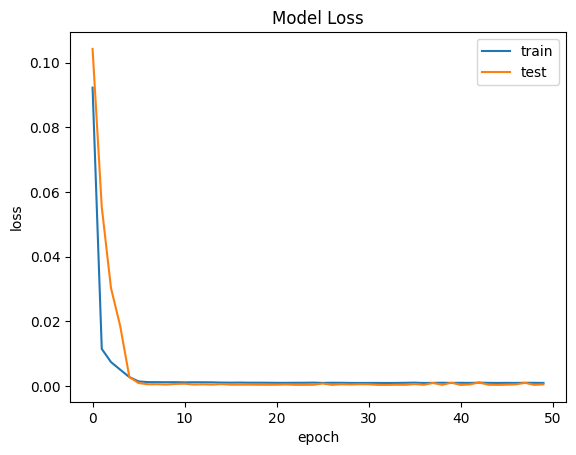

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Predictions

In [13]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_USD_price = model.predict(inputs)
predicted_USD_price = sc.inverse_transform(predicted_USD_price)

2023-06-11 21:39:54.136679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:39:54.138067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:39:54.139411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 4ms/step


2023-06-11 21:39:54.364563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 21:39:54.366083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 21:39:54.367025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
data_test['Close_Price_Prediction'] = predicted_USD_price
data_all = pd.concat([data_test, data_train], sort=False)

In [15]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Close_Price_Prediction': 'lstm'})
final_data = final_data[['Date','Close','lstm']]

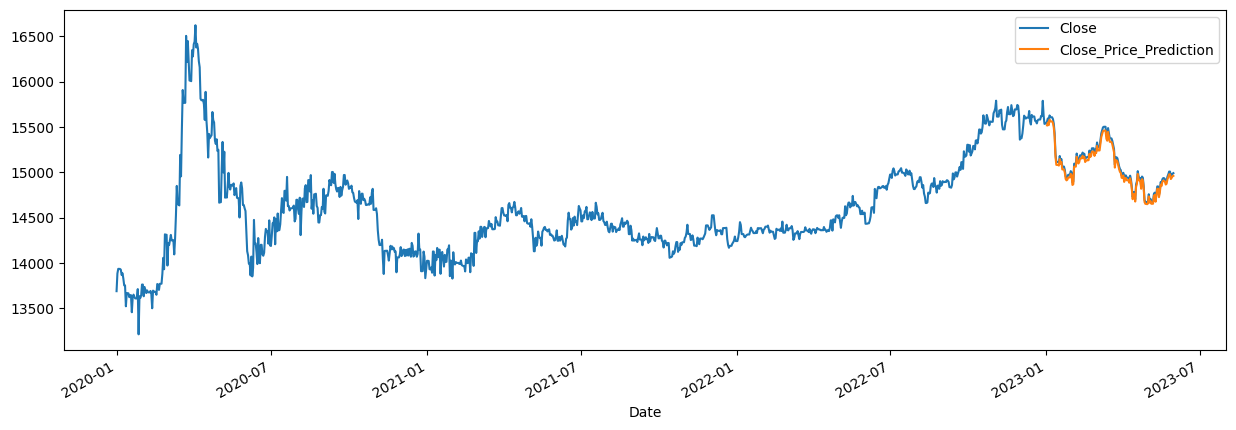

In [16]:
_ = data_all[['Close','Close_Price_Prediction']].plot(figsize=(15, 5))

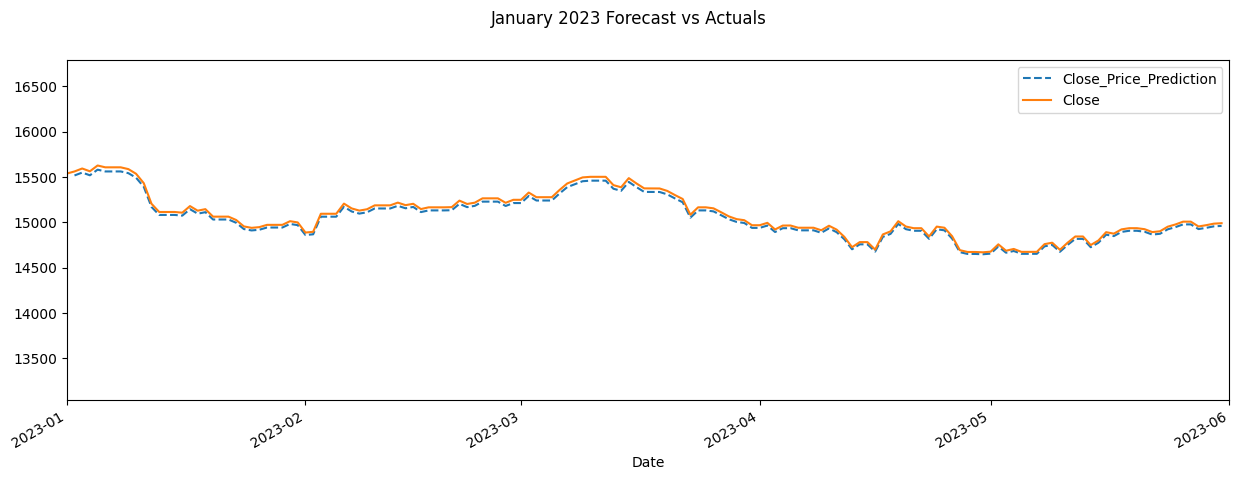

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Close_Price_Prediction','Close']].plot(ax=ax,
                                              style=['--','-'])
ax.set_xbound(lower='01-01-2023', upper='06-01-2023')
plot = plt.suptitle('January 2023 Forecast vs Actuals')

In [18]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)
    
matrices(data_test['Close'], data_test['Close_Price_Prediction'])

Mean Squared Error for prediction : 1051.626067072801
Mean Absolute Error for prediction : 31.86337630208328
Root Mean Squared Error for prediction : 32.428784545104385
